In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [11]:
def autolabelint(ax,rects,fsize,col):
    for rect in rects:
        ax.text(rect.get_x() + rect.get_width()/2 ,
            rect.get_height(),
            '%d' % int(rect.get_height()),
            ha='center',
            va='bottom',
            fontweight='bold',
            color = col,
            fontsize = ((fsize[1]+fsize[0])/2) + 5
           )

In [12]:
train = pd.read_csv("../train.csv")

In [13]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
finger = train.drop(columns=["keyword","location","id"])

In [15]:
def non_alphanum(x):
    return len(re.findall(r'[^a-zA-Z0-9 ]',x))
def hashtags(x): 
    return len(re.findall(r'#[a-zA-z0-9_]',x))
def arrobas(x):
    return len(re.findall(r'@[a-zA-z0-9_]',x))
def expresion(x):
    return (x.count('?') + x.count('!'))
def urls(x):
    re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
finger[["Caracteres","Palabras",\
            "Caracteres no alfanuméricos","Caracteres de expresión !?",\
                "Etiquetas", "Menciones"]] \
= finger["text"].apply(lambda x: pd.Series([len(x),len(x.split(" "))\
                                    ,non_alphanum(x),expresion(x)
                                            ,hashtags(x),arrobas(x)]))

finger["Caracteres no alfanuméricos"] = \
finger["Caracteres no alfanuméricos"] - finger["Etiquetas"] \
                                        - finger["Menciones"]

finger.drop(columns=["text"],inplace=True)
finger.head()

,target,Caracteres,Palabras,Caracteres no alfanuméricos,Caracteres de expresión !?,Etiquetas,Menciones
0,1,69,13,0,0,1,0
1,1,38,7,1,0,0,0
2,1,133,22,3,0,0,0
3,1,65,9,1,0,1,0
4,1,88,17,0,0,2,0


Text(0, 0.5, '')

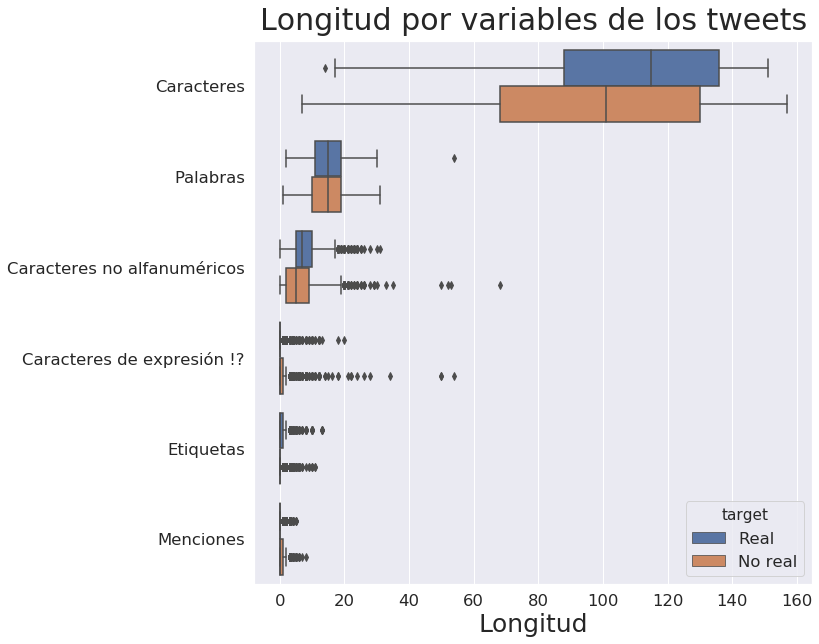

In [16]:
melted = pd.melt(finger, id_vars="target")
melted.loc[melted["target"] == 0, "target"] = "No real"
melted.loc[melted["target"] == 1, "target"] = "Real"
melted.rename(columns={"value":"Longitud","variable":"Variables"},inplace=True)
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=1.5)
plot = sns.boxplot(x='Longitud',y="Variables",data=melted,hue='target')
plot.axes.set_title('Longitud por variables de los tweets',fontsize=30, y=1.009)
plot.set_xlabel("Longitud",fontsize=25)
plot.set_ylabel("",fontsize=0)
#plot.get_figure().savefig("finger.png")

Uso expresiones regulares para hallar menciones, etiquetas y URLs en los tweets.

In [17]:
def get_links(x):
    links = list()
    l = re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',x)
    #for tup in l:
    #    links.append(chase_redirects(tup[0] + "://" + ''.join(tup[1:])))
    return l

def hashtags(x): 
    return re.findall(r'#[a-zA-z0-9_]{1,}',x)
def arrobas(x):
    return re.findall(r'@[a-zA-z0-9_]{1,}',x)

train[["Menciones","Etiquetas","Enlaces"]] =\
                        train["text"].apply(lambda x: pd.Series([arrobas(x),hashtags(x),get_links(x)]))

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7613 non-null   int64 
 1   keyword    7552 non-null   object
 2   location   5080 non-null   object
 3   text       7613 non-null   object
 4   target     7613 non-null   int64 
 5   Menciones  7613 non-null   object
 6   Etiquetas  7613 non-null   object
 7   Enlaces    7613 non-null   object
dtypes: int64(2), object(6)
memory usage: 475.9+ KB


/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

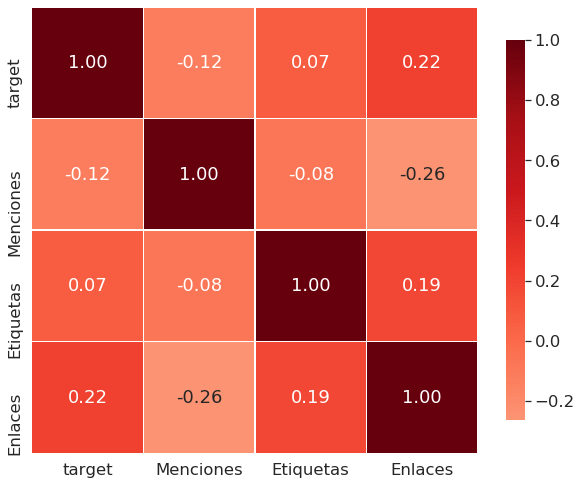

In [19]:
def correlation_heatmap(df):
    normalized_df=(df-df.mean())/df.std()
    correlations = normalized_df.corr(method='spearman')

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True,cmap="Reds", cbar_kws={"shrink": .70})
    plt.show();

cantidades = train[["target","Menciones","Etiquetas","Enlaces"]]

cantidades["Menciones"] = cantidades["Menciones"].apply(lambda x: len(x))
cantidades["Etiquetas"] = cantidades["Etiquetas"].apply(lambda x: len(x))
cantidades["Enlaces"] = cantidades["Enlaces"].apply(lambda x: len(x))
correlation_heatmap(cantidades)

/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/pcsor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

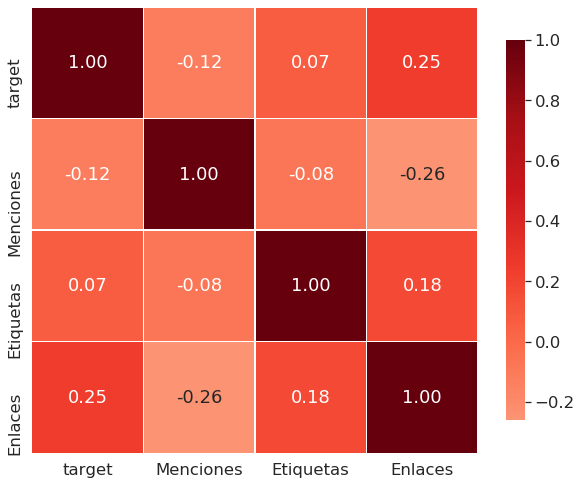

In [20]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True,cmap="Reds", cbar_kws={"shrink": .70})
    plt.show();

cantidades = train[["target","Menciones","Etiquetas","Enlaces"]]

cantidades["Menciones"] = cantidades["Menciones"].apply(lambda x: 0 if len(x) == 0 else 1)
cantidades["Etiquetas"] = cantidades["Etiquetas"].apply(lambda x: 0 if len(x) == 0 else 1)
cantidades["Enlaces"] = cantidades["Enlaces"].apply(lambda x: 0 if len(x) == 0 else 1)

correlation_heatmap(cantidades)

In [24]:
cantidades.to_csv('menciones.csv',index=False)

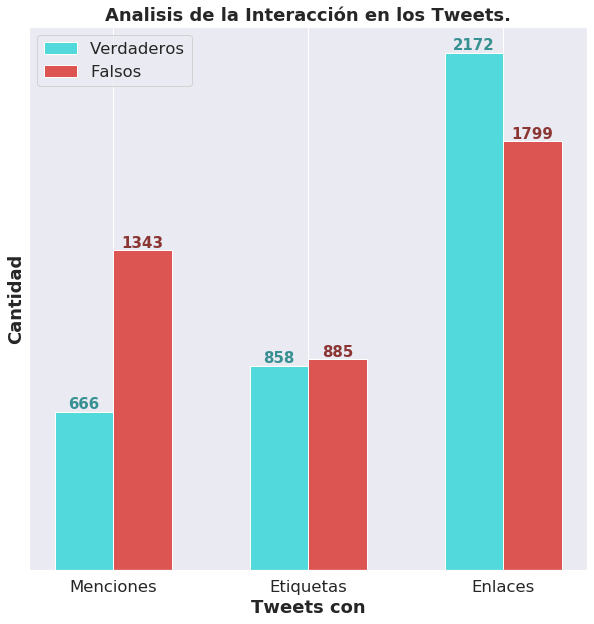

In [22]:
fsize = (10,10)
fig, ax = plt.subplots(figsize=fsize)
false = cantidades.loc[cantidades["target"] == 0]
true = cantidades.loc[cantidades["target"] == 1]
bars1 = [true["Menciones"].sum(),true["Etiquetas"].sum(),true["Enlaces"].sum()]
bars2 = [false["Menciones"].sum(),false["Etiquetas"].sum(),false["Enlaces"].sum()]
r1 = np.arange(len(bars1))
r2 = [x + 0.3 for x in r1]
rects1 = ax.bar(r1, bars1, color='#52D9DC', width=0.3, edgecolor='white', label='Verdaderos')
rects2 = ax.bar(r2, bars2, color='#DC5552', width=0.3, edgecolor='white', label='Falsos')

ax.set_title('Analisis de la Interacción en los Tweets.',fontweight='bold')
ax.set_ylabel('Cantidad',fontweight='bold')
ax.set_yticks([])
ax.xaxis.set_ticks_position('none')
plt.xlabel('Tweets con', fontweight='bold')
plt.xticks([r+0.15 for r in range(len(bars1))], ['Menciones', 'Etiquetas', 'Enlaces'])
autolabelint(ax,rects1,fsize,'#379092')
autolabelint(ax,rects2,fsize,'#8C3634')
plt.legend()

#### Limpieza de menciones

In [53]:
menciones = train.loc[train["Menciones"].str.len() > 0, ["Menciones","target"]]
print("Total de menciones: ",len(menciones["Menciones"].sum()))
# Menciones unicas por tweet
print("Total de menciones sin duplicados dentro de los tweets:  ",\
     len(menciones["Menciones"].apply(lambda x: list(set(x))).sum()))

Total de menciones:  2715
Total de menciones sin duplicados dentro de los tweets:   2708


In [54]:
def duplicada(x):
    if len(x) == len(set(x)):
        return False
    else:
        return True
menciones["mencion_duplicada"] = menciones["Menciones"].apply(duplicada)

In [55]:
menciones.loc[menciones["mencion_duplicada"]]

,Menciones,target,mencion_duplicada
1449,"[@GreenHarvard, @GreenHarvard]",1,True
1781,"[@meinlcymbals, @meinlcymbals]",0,True
1994,"[@IndiGo6E, @the, @the]",0,True
3205,"[@TfLBusAlerts, @TfLBusAlerts]",1,True
4999,"[@TeamHendrick, @TeamHendrick, @RIRInsider, @n...",0,True
5640,"[@KristinDavis, @UN, @Refugees, @UN, @Refugees]",0,True


cómo no tienen mucho significado y solamente se repiten 2 veces, voy a desecharlas

In [56]:
menciones.drop(columns = ["mencion_duplicada"],inplace=True)
menciones["Menciones"] = menciones["Menciones"].apply(lambda x: list(set(x)))

In [17]:
pd.Series(menciones["Menciones"].sum()).value_counts()

@YouTube            82
@ArianaGrande       11
@FoxNews             9
@POTUS               9
@Change              9
@emmerdale           8
@djicemoon           7
@justinbieber        7
@Stretcher           6
@MikeParrActor       6
@Towel               6
@usatoday            5
@USAgov              5
@YoungHeroesID       5
@AP                  5
@invalid             5
@ViralSpell          5
@worldnetdaily       4
@RaynbowAffair       4
@USATODAY            4
@Rexyy               4
@local_arsonist      4
@Michael5SOS         4
@LoneWolffur         4
@KurtSchlichter      4
@unsuckdcmetro       4
@DiamondKesawn       4
@Reuters             4
@Grazed              4
@TfLBusAlerts        3
                    ..
@HuffPostComedy      1
@beckyfeigin         1
@slimebeast          1
@Quora               1
@mccauleysdesign     1
@abcnorio            1
@ENTERSHIKARI        1
@nolesfan05          1
@SW_Trains           1
@_301DC              1
@muttatek            1
@bentossell          1
@DJJOHNBLaz

In [18]:
pd.Series(menciones["Menciones"].loc[menciones["target"] == 0].sum()).value_counts()

@YouTube            65
@ArianaGrande       11
@djicemoon           7
@emmerdale           7
@justinbieber        7
@MikeParrActor       6
@Change              5
@Towel               5
@invalid             5
@Stretcher           5
@Grazed              4
@local_arsonist      4
@RaynbowAffair       4
@DiamondKesawn       4
@LoneWolffur         4
@worldnetdaily       4
@USATODAY            3
@Blizzard_draco      3
@GOP                 3
@IAN_Hellfire        3
@iTunesMusic         3
@TrubGME             3
@jimmyfallon         3
@X                   3
@spinningbot         3
@dannyonpc           3
@eBay                3
@NickCannon          3
@iTunes              3
@ClaytonBryant       3
                    ..
@YOUNGSAFE           1
@ezralevant          1
@PlayStation         1
@RobertONeill31      1
@_itzSteven          1
@Kiwi_Karyn          1
@questergirl         1
@ExpressandStar      1
@Jannellix0          1
@RobThier_EN         1
@TheSewphist         1
@tonymcguinness      1
@mommyisbom

In [19]:
pd.Series(menciones["Menciones"].loc[menciones["target"] == 1].sum()).value_counts()

@YouTube            17
@FoxNews             8
@POTUS               6
@USAgov              5
@AP                  5
@Change              4
@unsuckdcmetro       4
@KurtSchlichter      3
@sharethis           3
@Michael5SOS         3
@smh                 3
@TfLBusAlerts        3
@ViralSpell          3
@MNPDNashville       3
@NASAHurricane       3
@Reuters             3
@usatoday            3
@Newz_Sacramento     2
@gofundme            2
@weathernetwork      2
@cnewslive           2
@JamaicaObserver     2
@ABC                 2
@9NewsGoldCoast      2
@YahooNews           2
@ameenshaikh3        2
@wocowae             2
@fewmoretweets       2
@1                   2
@nytimes             2
                    ..
@ScriptetteSar       1
@MackayIM            1
@Tony_Burke          1
@jorrynja            1
@JewishPress         1
@wwp                 1
@daisycuttertz       1
@zourryart           1
@RobertBEnglund      1
@aelinrhee           1
@HopefulBatgirl      1
@KlaraJoelsson       1
@Truly_Stin

In [81]:
menciones_separadas = pd.concat([menciones,menciones["Menciones"].apply(lambda x: pd.Series(x))],axis=1)
menciones_separadas.head()
#menciones_separadas.loc[~menciones_separadas[3].isna()]

,Menciones,target,0,1,2,3,4,5,6,7
31,[@bbcmtd],1,@bbcmtd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,[@PhDSquares],0,@PhDSquares,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,[@southridgelife],0,@southridgelife,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,[@Alexis_Sanchez],0,@Alexis_Sanchez,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,"[@Navista7, @News24680]",1,@Navista7,@News24680,NaN,NaN,NaN,NaN,NaN,NaN


#### Palabras en las menciones

In [90]:
#[re.findall('[A-Z][^A-Z]*', x) for x in menciones["Menciones"].sum()]
import nltk
[nltk.word_tokenize(x) for x in menciones["Menciones"].sum()]

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  Searched in:
    - '/home/mariano/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/home/mariano/ENTER/nltk_data'
    - '/home/mariano/ENTER/share/nltk_data'
    - '/home/mariano/ENTER/lib/nltk_data'
    - ''
**********************************************************************
